In [1]:
# imports
import numpy as np
import cv2
from deepface import DeepFace
import matplotlib.pyplot as plt
import os
import subprocess

In [2]:
# Loading the image to be edited
img = cv2.imread('static/faces.jpg')

# Idntifying all the faces and the gender of the person using deepface
obj = DeepFace.analyze(img, actions = ["gender"])

Action: gender: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Gender : Woman
Face : 


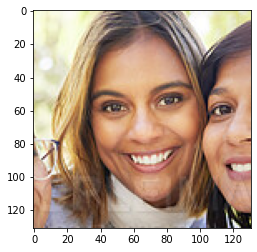


Gender : Woman
Face : 


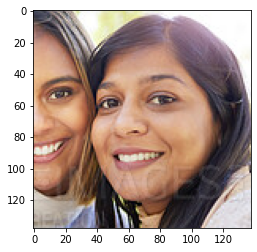


Gender : Man
Face : 


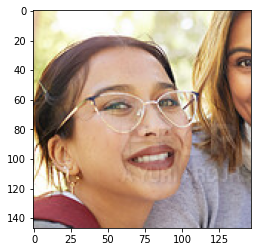

In [3]:
# Printing out the gender along with the faces detected
for temp_img in obj:
    x = max(temp_img["region"]["x"] - 25, 0)
    y = max(temp_img["region"]["y"] - 25, 0)
    w = temp_img["region"]["w"] + 50
    h = temp_img["region"]["h"] + 50
    print("Gender : " + temp_img["dominant_gender"])
    print("Face : ")
    plt.imshow(img[y:y+h, x:x+w][:,:,::-1])
    plt.show()
    print("")

In [4]:
# Function to return face from an image in a required aspect ration
def face_image_resize(img, resolution):
    detected_faces = DeepFace.analyze(img, actions = ["gender"], enforce_detection=False)
    detected = False
    detected_face = img
    if len(detected_faces) > 0:
        for temp_img in detected_faces[:1]:
            x = max(temp_img["region"]["x"] - 25, 0)
            y = max(temp_img["region"]["y"] - 25, 0)
            w = temp_img["region"]["w"] + 50
            h = temp_img["region"]["h"] + 50
            detected_face = img[y:y+h, x:x+w]
            detected = True
    new_image = cv2.resize(detected_face, (resolution[0], resolution[1]))
    return (new_image, detected)

In [5]:
def sub_process(path, args):
    python_file = path
    args = ['python', python_file] + args
    process = subprocess.Popen(args, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
    process.stdin.write('yes\n')
    process.stdin.flush()
    output, error = process.communicate()
    print("Output:\n", output)
    print("Error:\n", error)

In [6]:
# Deep Face Lab Commands
# python DeepFaceLab/main.py extract --input-dir DeepFaceLab/data_src --output-dir DeepFaceLab/workspace/data_src/aligned --detector s3fd
# python DeepFaceLab/main.py extract --input-dir DeepFaceLab/data_dst --output-dir DeepFaceLab/workspace/data_dst/aligned --detector s3fd
# python DeepFaceLab/main.py train --training-data-src-dir DeepFaceLab/workspace/data_src/aligned --training-data-dst-dir DeepFaceLab/workspace/data_dst/aligned --model-dir DeepFaceLab/workspace/model --model Quick96
# python DeepFaceLab/main.py merge --input-dir DeepFaceLab/data_dst --output-dir DeepFaceLab/workspace/data_dst/merged --model-dir DeepFaceLab/workspace/model --output-mask-dir DeepFaceLab/workspace/data_dst/masks --model Quick96 --aligned-dir DeepFaceLab/workspace/data_dst/aligned

In [20]:
# Exection of deepface commands and joining of image
def face_replace(path1, path2, img, coord, facial_area, name):
    python_file = 'DeepFaceLab/main.py'
    arg1 = [
    'extract', '--input-dir',
    'DeepFaceLab/data_src', '--output-dir',
    'DeepFaceLab/workspace/data_src/aligned'
    ]
    arg2 = [
    'extract', '--input-dir',
    'DeepFaceLab/data_dst', '--output-dir',
    'DeepFaceLab/workspace/data_dst/aligned'
    ]
    arg3 = [
    'train',
    '--training-data-src-dir', 'DeepFaceLab/workspace/data_src/aligned',
    '--training-data-dst-dir', 'DeepFaceLab/workspace/data_dst/aligned',
    '--model-dir', 'DeepFaceLab/workspace/model',
    '--model', 'Quick96'
    ]
    arg4 = [
    'merge',
    '--input-dir', 'DeepFaceLab/data_dst',
    '--output-dir', 'DeepFaceLab/workspace/data_dst/merged',
    '--model-dir', 'DeepFaceLab/workspace/model',
    '--output-mask-dir', 'DeepFaceLab/workspace/data_dst/masks',
    '--model', 'Quick96',"--aligned-dir",
    "DeepFaceLab/workspace/data_dst/aligned"
    ]
    os.system("rm DeepFaceLab/data_dst/*")
    os.system("rm DeepFaceLab/data_src/*")
    print(f"copying {path1} and {path2}")
    os.system("cp " + path1 + " DeepFaceLab/data_dst/")
    os.system("cp " + path2 + " DeepFaceLab/data_src/")
    print("executing command 1")
    sub_process(python_file, arg1)
    print("executing command 2")
    sub_process(python_file, arg2)
    print("executing command 3")
    sub_process(python_file, arg3)
    print("executing command 4")
    sub_process(python_file, arg4)
    x = coord[0]
    y = coord[1]
    w = coord[2]
    h = coord[3]
    x1 = facial_area[0]
    y1 = facial_area[1]
    w1 = facial_area[2]
    h1 = facial_area[3]
    new_img = cv2.imread(f'DeepFaceLab/workspace/data_dst/merged/{name}.png')
    new_swapped_img[y:y+h, x:x+w] = new_img[y1:y1+h1, x1:x1+w1]

In [21]:
# Executing all the functions for each face
male = 0.0
female = 0.0
new_swapped_img = img
for i, temp_img in enumerate(obj):
    x = max(temp_img["region"]["x"] - 25, 0)
    diff_x = temp_img["region"]["x"] - x
    y = max(temp_img["region"]["y"] - 25, 0)
    diff_y = temp_img["region"]["y"] - y
    w = temp_img["region"]["w"] + 50
    h = temp_img["region"]["h"] + 50
    gender = temp_img["dominant_gender"]
    if gender == "Man":
        path = "static/men/" + str(int(male)) + ".jpg"
        male = male + 1
    else: 
        path = "static/women/" + str(int(female)) + ".jpg"
        female = female + 1
    print("Using : " + path)
    (face_image, detected) = face_image_resize(cv2.imread(path), [w,h])
    print("Face detected : " + str(detected))
    cv2.imwrite("output/"+str(i)+"-orignal.png", img[y:y+h, x:x+w])
    cv2.imwrite("output/"+str(i)+"-changed.png", face_image)
    coord = [temp_img["region"]["x"],temp_img["region"]["y"],temp_img["region"]["w"],temp_img["region"]["h"]]
    facial_area = [diff_x,diff_y,w-50, h-50]
    if i == 0:
        face_replace("output/"+str(i)+"-orignal.png","output/"+str(i)+"-changed.png",img, coord, facial_area, str(i)+"-orignal")
cv2.imwrite("changed/swapped.png", new_swapped_img)

Action: gender:   0%|          | 0/1 [00:00<?, ?it/s] 

Using : static/women/0.jpg


Action: gender:   0%|          | 0/1 [00:00<?, ?it/s] 

Face detected : True
Using : static/women/1.jpg


Action: gender: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


Face detected : True
Using : static/men/0.jpg


Action: gender: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

Face detected : True


True

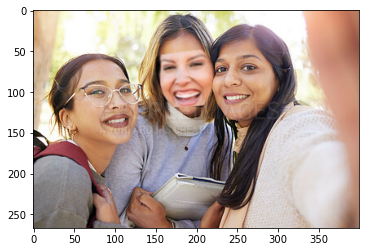

In [22]:
# Displaying the image verifying the output
plt.imshow(cv2.imread("changed/swapped.png")[:,:,::-1])
plt.show()